In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from functools import reduce
import wandb
import pandas as pd
from matplotlib import pyplot as plt
import opf
import opf.dataset
import utils
import logging
import seaborn as sns

logging.getLogger("pytorch_lightning").setLevel(logging.WARN)

save_dir = "/home/damow/Dropbox/Apps/Overleaf/Unsupervised Optimal Power Flow Using Graph Neural Networks/"
figure_dir = save_dir + "figures/"
table_dir = save_dir + "tables/"
log_dir = "../logs/"

def savefig(title: str):
    plt.savefig(f"{figure_dir}{title}.png")
    plt.savefig(f"{figure_dir}{title}.pdf")
    plt.savefig(f"{figure_dir}{title}.pgf")

In [3]:
api = wandb.Api()
runs = api.runs("damowerko/opf", filters={"tags": "sweep1"})
data = [{**run.config, **run.summary} for run in runs]
df = pd.DataFrame(data)

In [4]:
parameters = ["s", "t", "K", "F", "L", "lr"]
best_idx = df[df["test/inequality/rate"] < 0.01]["test/cost"].idxmin()
best_parameters = {name: df.iloc[best_idx][name] for name in parameters}
display(best_parameters)

{'s': 10, 't': 500, 'K': 8, 'F': 32, 'L': 2, 'lr': 0.0001}

In [5]:
# indices and column values to be renamed
rename_dict = {
    "lr": "$\eta$",
    0.00001: "1e-5",
    0.0001: "1e-4",
    0.001: "1e-3",
    "test/cost": "Generation Cost",
    "test/inequality/rate": "Constraint Violation Rate",
}
rename = lambda param: rename_dict[param] if param in rename_dict else param
renamed_params = {rename(k): rename(v) for k, v in best_parameters.items()}

values = ["test/cost", "test/inequality/rate"]
for params in [("K", "F"), ("s", "t"), ("L", "lr")]:
    filename = f"{table_dir}search_{params[0]}{params[1]}.tex"
    selected = []
    for param_name, param_value in best_parameters.items():
        if param_name in (params[0], params[1]):
            continue
        selected.append(df[param_name] == param_value)
    selected = reduce(lambda a, b: a & b, selected)
    table = df[selected].pivot(params[0], params[1], values)

    # Rename the indices and index names based on rename_dict
    table = table.rename(columns=rename_dict, index=rename_dict)
    params = list(map(rename, params))
    table.index.name = params[0]
    table.columns.names = [None, params[1]]

    style = table.style.format("{:0.4f}").applymap(
        lambda x: "font-weight:bold;",
        subset=(renamed_params[params[0]], (slice(None), renamed_params[params[1]])),
    )
    display(style)
    style.to_latex(buf=filename, convert_css=True, hrules=True)


In [18]:
import utils
from IPython.display import clear_output

dm = opf.dataset.CaseDataModule("case30", "../data", adj_threshold=0.01)
runs = api.runs("damowerko/opf", filters={"tags": "case30_cost_weight"})
data = []
for run in runs:
    model = opf.utils.create_model(dm, run.config)
    utils.load_checkpoint(model, run.id, log_dir)
    data.append(utils.test(model, dm))
clear_output()

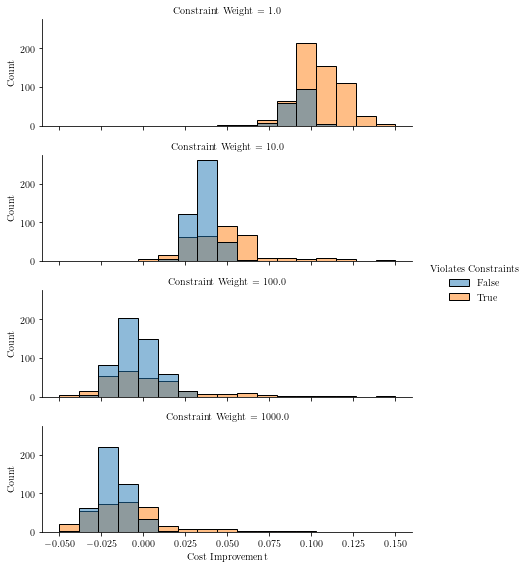

In [62]:
for i, run in enumerate(runs):
    data[i][list(run.config.keys())] = list(run.config.values())
df = pd.concat(data, ignore_index=True)

df["Violates Constraints"] = df["test/inequality/error_max"] > 0.0001
df["Cost Improvement"] = df["acopf/cost"] - df["test/cost"]
df["Constraint Weight"] = 1 / df["cost_weight"]

# df = df.loc[~df["Violates Constraints"]] # discard violations
df = df.loc[df["Constraint Weight"] <= 1000] # look at 4 weights

sns.displot(
    df,
    x="Cost Improvement",
    fill=True,
    kind="hist",
    hue="Violates Constraints",
    binrange=(-0.05,0.15),
    common_norm=True,
    row="Constraint Weight",
    height=2,
    aspect=3,
)
savefig("case30/cost_weight")
